In [1]:
import NeuralTSNE as ntsne
import torch
from torch.utils.data import Subset, TensorDataset
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import Trainer
import numpy as np

In [2]:
train, test = ntsne.DatasetLoader.get_dataset("mnist")

In [3]:
len(train), len(test)

(60000, 10000)

In [4]:
train_labels = train.targets
test_labels = test.targets

In [5]:
val = Subset(train, range(0, 10000))
train = Subset(train, range(10000, len(train)))

In [6]:
len(train), len(val), len(test)

(50000, 10000, 10000)

In [7]:
class CustomModel(ntsne.TSNE.BaseModel):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.sequential_stack = torch.nn.Sequential(
            torch.nn.Linear(784, 512),
            torch.nn.GELU(),
            torch.nn.Linear(512, 256),
            torch.nn.ELU(),
            torch.nn.Linear(256, 10),
            torch.nn.GELU(),
            torch.nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.sequential_stack(x)
    
    @property
    def in_features(self):
        return self.sequential_stack[0].in_features

In [8]:
model = torch.nn.Sequential(
            torch.nn.Linear(784, 512),
            torch.nn.GELU(),
            torch.nn.Linear(512, 256),
            torch.nn.ELU(),
            torch.nn.Linear(256, 10),
            torch.nn.GELU(),
            torch.nn.Linear(10, 2)
        )

In [7]:
from typing import OrderedDict


model = OrderedDict(
    [
        ("linear1", torch.nn.Linear(784, 512)),
        ("gelu1", torch.nn.GELU()),
        ("linear2", torch.nn.Linear(512, 256)),
        ("elu1", torch.nn.ELU()),
        ("linear3", torch.nn.Linear(256, 10)),
        ("gelu2", torch.nn.GELU()),
        ("linear4", torch.nn.Linear(10, 2))
    ]
)

In [8]:
param_tsne = ntsne.TSNE.ParametricTSNE(
    loss_fn="kl_divergence",
    perplexity=30,
    batch_size=1000,
    early_exaggeration_epochs=0,
    early_exaggeration_value=0,
    max_iterations=500,
    n_jobs=31,
    model=model,
)

In [9]:
print(param_tsne.model)

NeuralNetwork(
  (sequential_stack): Sequential(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (gelu1): GELU(approximate='none')
    (linear2): Linear(in_features=512, out_features=256, bias=True)
    (elu1): ELU(alpha=1.0)
    (linear3): Linear(in_features=256, out_features=10, bias=True)
    (gelu2): GELU(approximate='none')
    (linear4): Linear(in_features=10, out_features=2, bias=True)
  )
)


In [10]:
early_stopping = EarlyStopping(monitor="val_loss", min_delta=1e-5, patience=10)

In [11]:
trainer = Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    log_every_n_steps=1,
    max_epochs=param_tsne.max_iterations,
    callbacks=[early_stopping]
)

reducer = ntsne.TSNE.Classifier(param_tsne, False, lr=1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\miniconda3\envs\tf\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [12]:
traind, testd = param_tsne.create_dataloaders(train, test)
vald, _ = param_tsne.create_dataloaders(val, None)

In [13]:
torch.set_float32_matmul_precision('high')

In [14]:
trainer.fit(reducer, traind, [vald])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params
----------------------------------------
0 | model | NeuralNetwork | 535 K 
----------------------------------------
535 K     Trainable params
0         Non-trainable params
535 K     Total params
2.143     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\miniconda3\envs\tf\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
Calculating P: 100%|██████████| 10/10 [00:10<00:00,  1.02s/batch]


d:\miniconda3\envs\tf\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Calculating P: 100%|██████████| 50/50 [00:51<00:00,  1.03s/batch]

Epoch 0:   6%|▌         | 3/50 [00:00<00:03, 15.00it/s, v_num=12, train_loss_step=3.330]

Epoch 29: 100%|██████████| 50/50 [00:06<00:00,  7.89it/s, v_num=12, train_loss_step=1.080, val_loss_step=1.340, val_loss_epoch=1.420, train_loss_epoch=1.250]


In [20]:
Y = trainer.predict(reducer, testd)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\miniconda3\envs\tf\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 30.54it/s]


In [21]:
#convert predict batches to numpy
Y = np.concatenate(Y, axis=0)

In [22]:
Y.shape

(10000, 2)

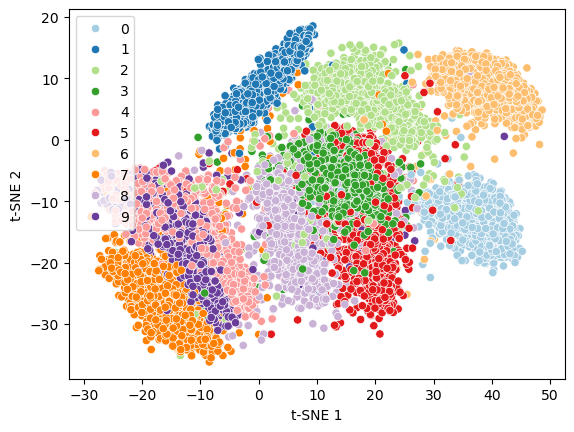

In [23]:
ntsne.MnistPlotter.plot(Y, test_labels)